# My First Kaggle

## Wranglings, Regressions, and Reflections 



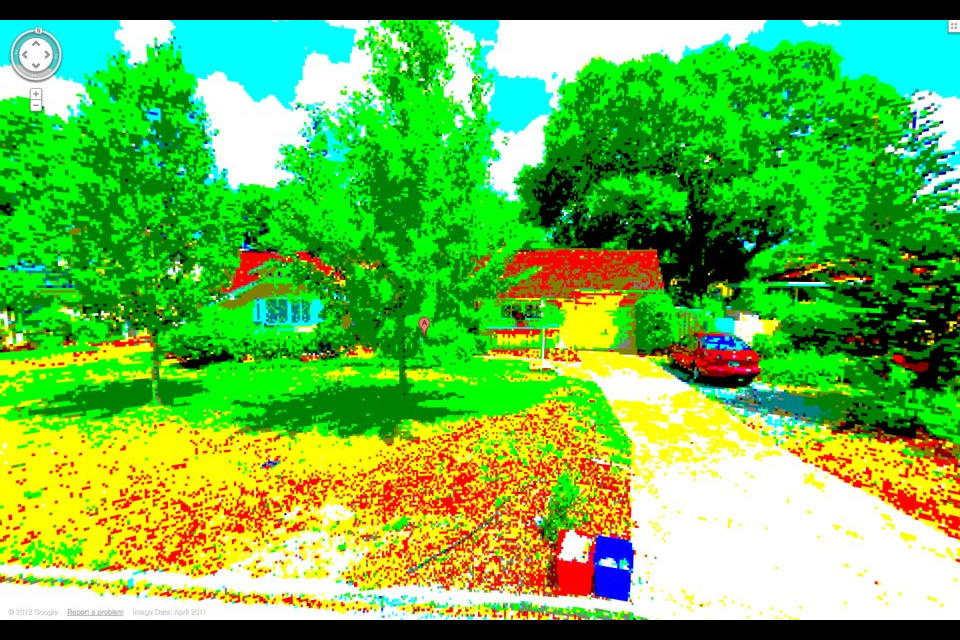

This notebook will be an attempt to tackle the Kaggle beginners competition for [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Kaggle is a forum for learning and competing with machine learning and even offers cash prizes sponsored by companies looking to incorporate the models. I just got my hands on a notebook for Kaggle titanic problem tutorial to another beginner problem set(prepared by Andrew Conti and is available from github [here](https://github.com/agconti/kaggle-titanic)
 meant to address this Kaggle [introductory competition](https://www.kaggle.com/c/titanic)), which partly inspired this approach of code-blogging (is code-blogging a thing? if not I think we should make it one).

Thje first step will be to evaluate and preprocess the data to prepare them for machine learning algorithms. Once complete, I will lean on a demonstration for training this type of regression problem available in Chollet's 'Deep Learning With Python' section 3.8 (a book still pending release but have reviewed the MEAP presale version and I highly recomend this text - presale available [here](https://www.manning.com/books/deep-learning-with-python).

This notebook is being run initially on my local Anaconda installation for data exploration and processing, and then once is time for training will transition to a AWS EC2 AMI instance which comes preloaded with several deep learning frameworks such as tensorflow, keras, etc. (Only concern is macbook is a little underpowered (M chip) so hopefully won't be an issue.) For budgetary considerations will mostly work off of the micro (cheapest hardware) instance but as venture into deeper models may spend some training time on one of the versions that includes GPU hardware for speed considerations. Although these GPU instances can be pricier, they are offered on a $/hr pay-as-you-go basis, so as long as you don't leave running outside of training period it is managable. You can view a list of available AWS deep learning AMI's [here](https://aws.amazon.com/marketplace/search/results?searchTerms=Deep+Learning+AMI&page=1) - Chollet recomended the official Amazon Ubuntu version although I already have a bitfusion version running so will run that for now. A startup guide for initiating a bitfusion instance is available [here](https://bitfusion.atlassian.net/wiki/spaces/AMI/pages/41812175/AMI+User+Guide).

*As an aside I find it unabashedly cool that this same list of AWS deep learning AMI's includes one from [BayesForge](https://aws.amazon.com/marketplace/pp/B06Y6BNHD3?qid=1502640747029&sr=0-11&ref_=srh_res_product_title#product-description) which in addition to deep learning frameworks is also preloaded with all of the public environments for quantum computing from likes of Rigetti, IBM, D-Wave, or open source equivalents.

**As another aside it would stand to reason that AWS wouldn't be the only platform offering GPU enabled virtual machines pre-loaded with deep learning frameworks, however when I just checked [Google Cloud Compute Engine](https://cloud.google.com/compute/pricing) the GPU enabled instances were still in beta, so who knows maybe they're waiting to offer machines running on that fancy new TPU chip that they started [publicizing](https://cloud.google.com/blog/big-data/2017/05/an-in-depth-look-at-googles-first-tensor-processing-unit-tpu) earlier this year.
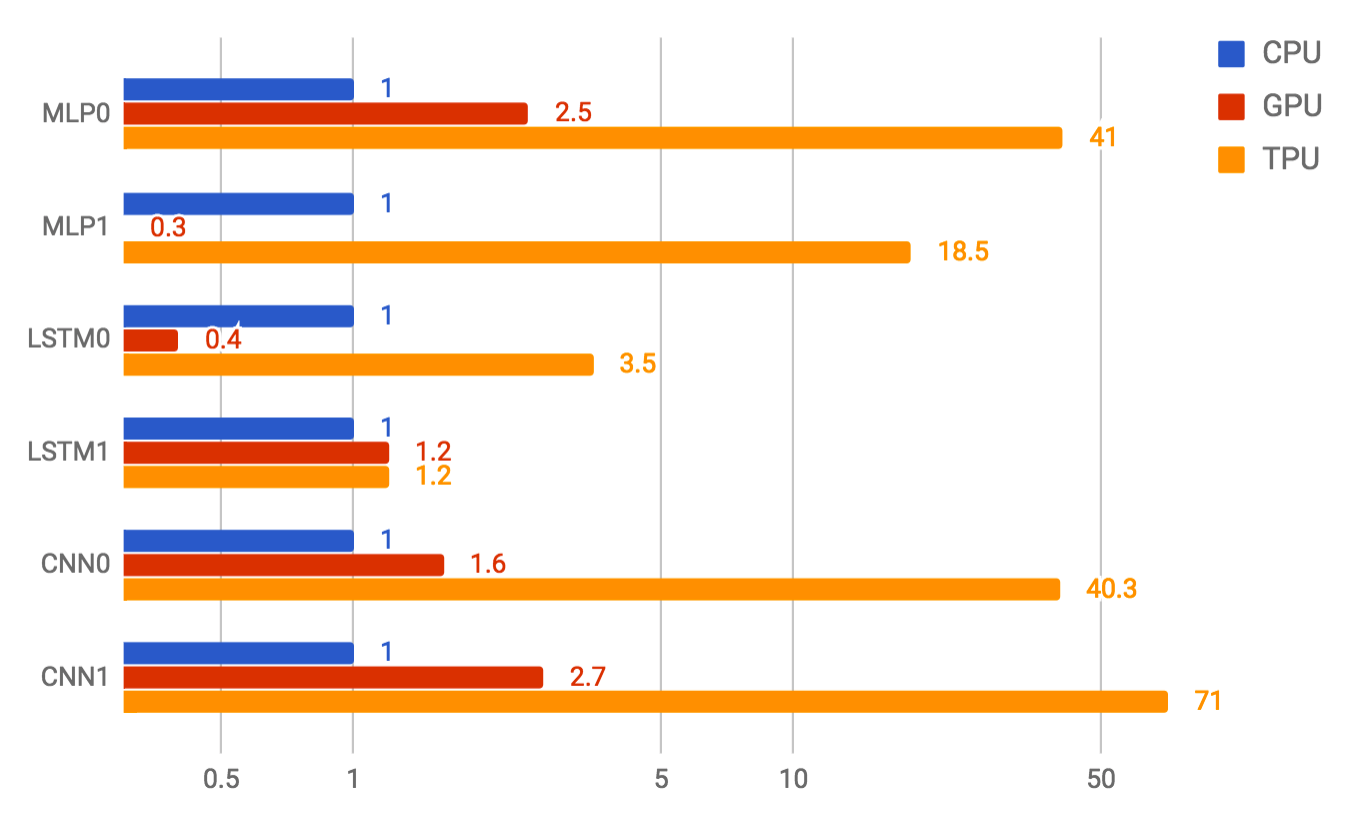

Although in preperation for this my first Kaggle competition have read several texts ranging from introductory to advanced, sat a few MOOC's, and toyed around with Python, this will be my first attempt to work with a real live data set. As such will lean heavily on these tutorials and document assumptions and other sources of inspriation (read google search, stack overflow, etc) throughout. I'll probably fall a little short of potential in custom data explorations but it's a simple dataset so shouldn't be too big of a deal.

Yeah so anyway here we go.

# Part 1: Data Exploration and Preprocessing

To make my life easy from an imports standpoint will just copy the list of imports from that titanic tutorial notebook, which should cover what we're trying to address here.

In [10]:
#First we address imports. These are all lifted directly from Titanic tutorial
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import datasets, svm

So if you're trying to follow along and running these imports from a bitfusion virtual machine (as I did initially), you may recieve an import error with the statsmodels.api (although this won't be an issue if you're running this from Anaconda) - not to worry statsmodels it turns out was just a statistics library used in the titanic notebook which I will just not use here. Actually you know what since am not using will just delete from the import list to avoid any bugs that could result from the import error.

Another error from the titanic tutorial imports you'll see independant of which environment you're running your notebook in is associated with a library called [KaggleAux](github.com/agconti/kaggleaux) which appears to be a custom tool for preparing Kaggle data in some fashion - I'll just intend to do any of these steps manually so will delete the KaggleAux import as well to avoid another error.

So current agenda is to read training data, explore, decide on which features to include in our model, how they should be transformed to improve training efficiencyt, then begin data processing to prepare for regression analysis. Note that the output of our data processing will be to convert the training data set to corresponding dataframes x_train (training features), y_train (training labels i.e. house prices), x_val (validation features), y_val (validation labels). We'll also need to perform comparable transforations on the test data to create x_test (test features). Ok we're ready to look at the data now. 

In [88]:
# import training data to pandas dataframe
df = pd.read_csv("train.csv") 

# view the first five rows
df[:5]


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

Note that missing values are represented as "NaN" which I assume stands for not a number(?).


So even though there are 81 columns to this dataset (reference the shape description at the bottom of the output), there are only ~20 displayed. Is it skipping columns like it is skipping rows? But I don't see any marking to indicate where such a skipping is taking place. (oh wait just found where the skpping is taking place, between Utilities and PoolArea)

Since this view isn't showing the full list of columns, will parrallel open the training data file in a visual data mining utility I downloaded for this purpose - a tool called RapidMiner which is a free utility for datasets below 10,000 entries, can be downloaded [here](https://rapidminer.com/).

Rapidminer appears to be capable of performing data transformations, however for now will try to limit data processing to this notebook as based on a google search my impression was that it is more common to manipulate data through python than with a visual editing platform.

There are some other handy features in Rapidminer beyond it's core functionality of transformations. Some I have found so far include the ability to easily view basic attributes of each column, it is also possible to view simple charts - for instance one use could be for those columns displaying textual categories instead of numeric values, you could view a scatter plot of those categories comparied to home price and eyeball to see if any expected predictive power from those distributions. Note that more sophisticated statistical analysis appears unavailable, although if I am interpretting it correctly one way that could quickly rank the distributions of a column of categories such as for instance (just to pick one) MSZoning would be to select that column in the Statistics feature, show chart, and then choose chart type of distribution with a comparison against house prices - a screen grab of this type of output below next paragraph.

At this stage in Titanic tutorial, author suggests dropping a few rows that might be populated with primarily missing cells and thus won't have much predictive power. Upon inspection in Rapidminer, the primary columns that have mostly NA values are PoolQC, Fence, and MiscFeature. However before blindly striking these columns, my thought is that at minimum the inclusion of a pool should have some measurable impact on a home price, and since this is a manageable three columns will quickly turn back to Rapidminer tool and view the distributions vs home price as described above. Here for instance is the distributions of categories under PoolQC column:
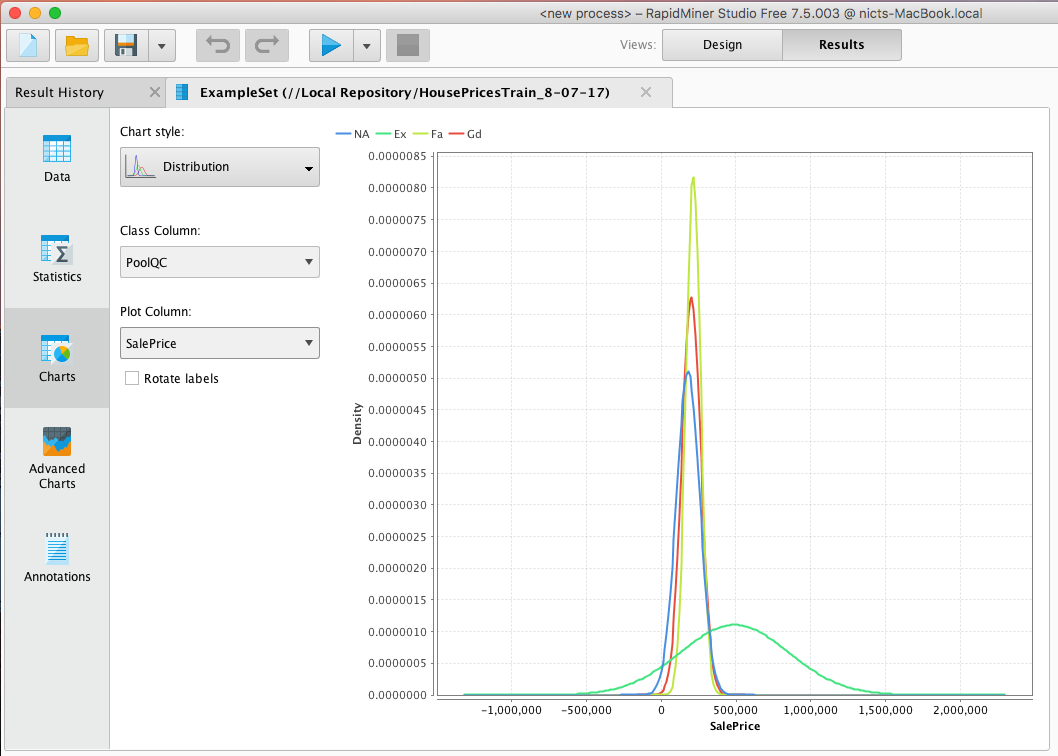

Were the pool classification benign on house price, I would have expected a distribution comparable to NA with simply different magnitudes. But clearly Ex (exterior pool) increases a home value. I can't for the life of me imagine why, my father likes to say that a swimming pool is like a hole in the ground you dig in your back yard and then pour money into - and don't even get me started on a certain neighbor with a giant oak tree overhanging over that same money pit which somehow drops about three times its weight in leaves but I digress.

So clearly PoolQC is worth keeping in our model, as for the other two a quick inspection reveals both Fence and MiscFeature have at least one category that appears to have measurable effect on price distribution - thus will forgo dropping any of these three even though they all have a high prevelance of missing cells. That is not to say won't drop any columns - I would expect that the more columns we keep in our model the higher the training expense of computation, assuming this Titanic tutorial will hopefully go further into how to evaluate potential inclusions of features as we start looking at data graphically. Speaking of which that's actually the next step. 


So upon reviewing the titanic tutorial data explorations, it appears they've taken some approaches to visulaization that are pretty specific to their particular problem (which happens to be a categorization problem between Kate and Leo, and don't even get me started about why Leo had to swim. They could have easily fit two people, I mean just look:
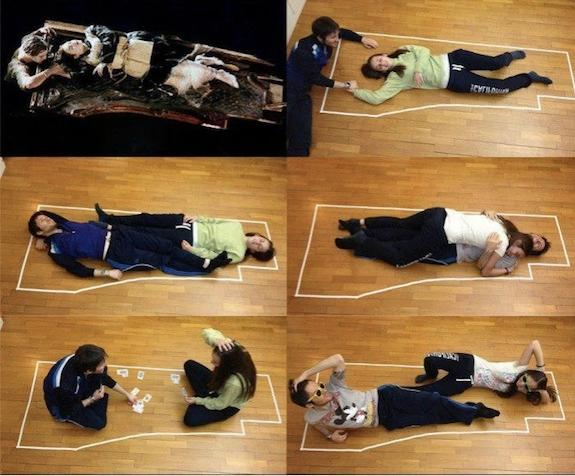

Since ours is a regression problem and espicially since our feature set is much more elaborate (81 columns vs Titanic's 12), it may be worth a more structured approach to visualization. Of course we always have Rapidminer to fall back on, but I know have seen some demonstrations of Python easy visulaizations in some prior readings so am going to do a little digging real quick, hold please.

So one worthwhile text have peruesed was Ge-ron's [Hands on Machine Learning with Sci-Kit and Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=sr_1_fkmr2_1?ie=UTF8&qid=1502421671&sr=8-1-fkmr2&keywords=Hands+on+Machine+Learning+with+Sci-Kit+and+Tensorflow), so will start by attempting some of the data visualizatino tips they suggested in second chapter, such as histograms and scatter plots.

*As is not unusual for generous authors in this field, the code from this same text is available in format of jupyter notebooks on github [here](https://github.com/ageron/handson-ml).

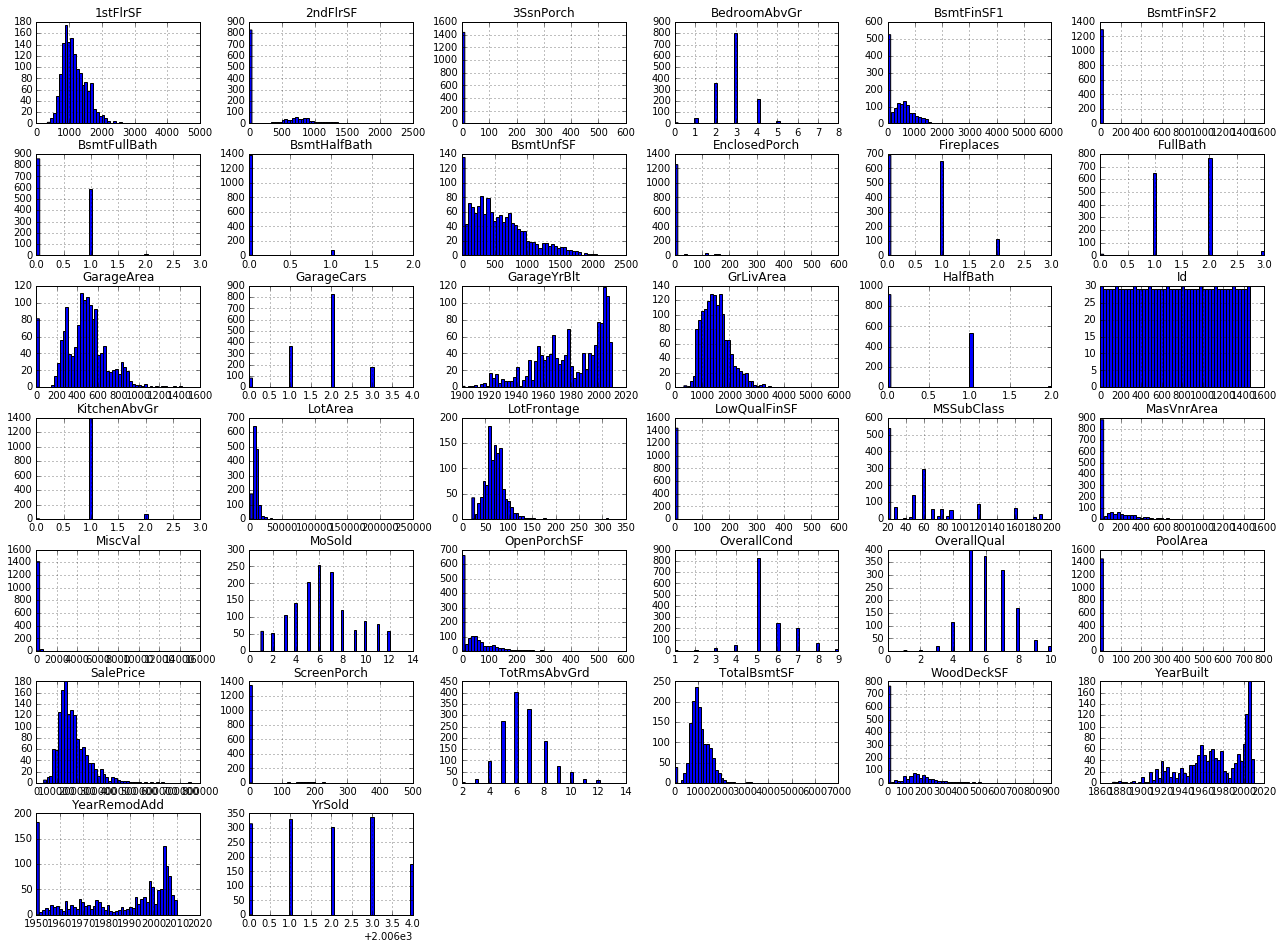

In [12]:
# let's try a few histograms
df.hist(bins=50, figsize=(22,16))
plt.show()

So I was a littel confused about the output of this histogram plot at first because there are only ~38 charts shown here in comparison to the 81 columns. However I believe what is going on here is that the histogram function only displays sets for those columns with numerical values. It's not clear if missing values / NaN's / or the like might prevent additional displays. Actuallky that reminds me at some point am going to have to verify that we have some approach for cells with missing values - either going to have to input a plug number such as median for the column or the like, note to self etc.
Pause
The good news is just verified that although there are some missing cells in the numerical columns, they did not prevent them showing on in this histogram.

So inspecting these figures, looking for points of interest. Here are some that grab my attention along with their description:
Id (as expected this is just a counter)
PoolArea (Pool area in square feet appears to all show same value?)
- since only have 7 nonzero points here (looked at the rapidminer scatterplot), with a significant outlier, I worry there's not enough points here to extract anything meaningful, this is best candidate yet for a dropped column
ScreenPorch (Screen porch area in square feet) - doesn't appear to be a lot of information from this chart however when zoom in using rapidminer chart there does appear a small depth the the range.
MiscVal ($Value of miscellaneous feature)
- this would only be of value when combined with the misc feature categorization, and since almost all fo the values here are 1 am thinking this is another good candidate for a drop

Actually the PoolArea comment above got me wondering if there are any other points with insufficient data for any real feature extraction, another perusal along that lens makes me also question these columns:
- 3SsnPorch (Three season porch area in square feet) =>drop, after inspection in rapidminer not enough corelation with price
- LowQualFinSF (Low quality finished square feet (all floors)) => drop
- BsmtHalfBath (Basement half bathrooms) => after rapidminer inspection decided to keep this one

So in summary, after reviewing the histogram plot (in conjunction with a few glances at rapidminer), have decided we will drop the following columns:
Id (actually not positive can drop this one, this might be neccesary for Kaggle submission)
PoolArea
ScreenPorch
MiscVal
3SsnPorch
LowQualFinSF
BsmtHalfBath

(will set these aside for now so as to perform the dataset transformations all at once).

Another dataset consideration that will be less determined by charts and visualizations and more by common sense applied to understanding your dataset will be from just walking through the description of features one by one and ensuring that they all make sense with respect to any predictive power and that they all work in isolation. Our data set here has 81 columns which to my untrained inmagination strikes me as on the high side. The goal here is always to first get a simple working model established to serve as a baseline and only they attempt to address the problem with more sophisticated resources, and am starting to wonder if maybe instead of starting with histograms and visualizations should have attempted this first, and you know what what the hell would be fun to get something working before more in depth dataset explorations, so I'll turn my attention here to developing a simple baseline model based on a bare minimum feature set. 

The assumption is that of our 81 features there are probably some that are most significant in evaluation. For example, based on my admittedly limited exposure to housing market in recent years would expect that some of the dominant features would be those like neighborhood (location location location after all), square footage, year of construction, quality of construction, and just to throw one more in since it appeals to my mechanical engineering background let's include inclusion of central air. Those five features are as follows:

Neighborhood
GrLivArea
YearBuilt
OverallQual
CentralAir
(I'm not positive but assuming we won't need the Id feature too for submitting input to Kaggle, still need to read a tutorial on submission process, note to self...)

Oh yeah obviously we'll need the sales price column too for training duh:
SalePrice

*It occurs to me that there are probably statistical ranking tools in Python to rank a feature set by correlation with a target variable (some kind of p value matrix, right?), that would be a more scientific aprpoach to selecting these bare minimum features perhaps, but I'm too excited for having already selected my intuitive bare minimum features so decided not to climb down that rabbit hole just yet.



In [13]:
#trim dataset to "bare minimum" features
df_bm = df.loc[:,['Neighborhood','GrLivArea','YearBuilt','OverallQual','CentralAir','SalePrice']]
df_bm[:5]

Neighborhood  GrLivArea  YearBuilt  OverallQual CentralAir  SalePrice
0      CollgCr       1710       2003            7          Y     208500
1      Veenker       1262       1976            6          Y     181500
2      CollgCr       1786       2001            7          Y     223500
3      Crawfor       1717       1915            7          Y     140000
4      NoRidge       2198       2000            8          Y     250000

So the theory is that this paired down feature set will be much less computationally expensive to train and will allow me to establish a baseline to measure performance against once I start training with a more elaborate feature set.

So some of these features are numeric integers and we can just leave those as is. For those textual classifications (nbeighborhood and cetral air) we could a) assign a numeric value to each classification, or b) assign a sparce identity vector via "one hot encoding". I think have read that it is easier to train with a sparse vector so will atempt option b. Oh yeah at some point will also need to normalize the nueric values to range -1,1 centered on median etc.

But first am curious how many missing values we are dealing with and how we should address that.

In [14]:
df_bm.isnull().values.ravel().sum()


0

Cool so if am interpretting this correctly that means we don't have to worry about missing values for this first pass which makes our lives a little easier.

Oh and sidetrack alert I just stumbled acdcross the correlatino matrix was talking about earlier, am curious about applying to our pared down feature set so will give that a quick try:

In [15]:
corr_matrix = df_bm.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
YearBuilt      0.522897
Name: SalePrice, dtype: float64

So the selection of features appears reasonable, note it is only providing values for numerical features, and you know what just because I like tangents am curious how we did in selecting these features in first place so just going to back up to the full dataset and do a similar quick ranking of corelation:

In [16]:
corr_matrix = df.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

So yeah we did reasonably well in selecting features based on common sense, still it probably wouldn't be too much trouble to incorporate just a few more of the stronger sets, and looking here two that jump out are 
GarageCars
TotalBsmtSF

Am not going to add GarageArea since is redundant with GarageCars (which has a stronger correlation), also not going to add 1stFlrSF since that is already encoded in the total square feet above ground GrLivArea. Speaking of complementary features, it strikes me that full baths and half baths are usually in MLS listings counted together, assigning half baths value of 0.5, so perhaps it would make sense here to take a similar approach and combine the count of full baths and half baths into single value - it would be confirmation if we did this and the correlation measure was higher than the full bath count. Would that exercise be deviating from our goal of bare minimum model? Probably, but kind of want to figure out how to do this so am going to tackle it here anyway. 

So we will make a new bathroom column using this derivation:
TotBathroom = FullBath + (0.5) * HalfBath + BsmtFullBath + (0.5) * BsmtHalfBath

Note that BsmtHalfBath was the only one of these features that was negatively correlated with sales price, perhaps there could be argument for leaving it out of this summation but am a little OCD so just going to include as anything else wouldn't be true.

And you know while we're at it might as well incorporate basement square feet into above ground square feet, however since I suspect there will be some cases where basements are unfinished and don't contribute as much value, will subtract unfinished square feet from total square feet as a way to counter this effect.

So area derivation will be as:
TotSF = GrLivArea + TotalBsmtSF - BsmtUnfSF

Once we complete these transformations we'll want our complete feature set to be:

'Neighborhood','TotSF','YearBuilt','OverallQual','CentralAir','TotBathroom','SalePrice'

*Hi, Nick from the future here. After performing all of the data transformations and running through the training and testing, I expect that a few additional features could reasonable be expected to have improved our predictive capability, if I were to do this again probably would include at least some of the following. Granted these would have neccesitated a wider hidden layer but am sure we could have accomodated.
Fireplaces
MasVnrType
PoolQC
SaleCondition
RoofMatl


Great so now that we have our list of desired features lets recreate the bare minimum dataframe, this time including the other columns we want to include in our manipulations. We'll also double check again for missing values.

In [17]:
#expanded bare minimum set to prep for manipulations
df_bm = df.loc[:,['Neighborhood','GrLivArea','YearBuilt','OverallQual','CentralAir','SalePrice','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtUnfSF']]
df_bm[:5]

Neighborhood  GrLivArea  YearBuilt  OverallQual CentralAir  SalePrice  \
0      CollgCr       1710       2003            7          Y     208500   
1      Veenker       1262       1976            6          Y     181500   
2      CollgCr       1786       2001            7          Y     223500   
3      Crawfor       1717       1915            7          Y     140000   
4      NoRidge       2198       2000            8          Y     250000   

   FullBath  HalfBath  BsmtFullBath  BsmtHalfBath  TotalBsmtSF  BsmtUnfSF  
0         2         1             1             0          856        150  
1         2         0             0             1         1262        284  
2         2         1             1             0          920        434  
3         1         0             1             0          756        540  
4         2         1             1             0         1145        490

In [18]:
#check for missing values in data set
df_bm.isnull().values.ravel().sum()

0

In [19]:
#Create total bathroom count TotBathroom
#TotBathroom = FullBath + (0.5) * HalfBath + BsmtFullBath + (0.5) * BsmtHalfBath
TotBathroom = df_bm.FullBath + 0.5 * df_bm.HalfBath \
+ df_bm.BsmtFullBath + (0.5) * df_bm.BsmtHalfBath

#add column to data set
df_bm['TotBathroom'] = TotBathroom

#remove columns we don't need anymore
del df_bm['FullBath']
del df_bm['HalfBath']
del df_bm['BsmtFullBath']
del df_bm['BsmtHalfBath']

#Create total square foot TotSF
#TotSF = GrLivArea + TotalBsmtSF - BsmtUnfSF
TotSF = df_bm.GrLivArea + df_bm.TotalBsmtSF - df_bm.BsmtUnfSF

#add column to data set
df_bm['TotSF'] = TotSF

#remove columns we don't need anymore
del df_bm['GrLivArea']
del df_bm['TotalBsmtSF']
del df_bm['BsmtUnfSF']


In [20]:
#view dataframe to confirm everything checks out
df_bm[:5]

Neighborhood  YearBuilt  OverallQual CentralAir  SalePrice  TotBathroom  \
0      CollgCr       2003            7          Y     208500          3.5   
1      Veenker       1976            6          Y     181500          2.5   
2      CollgCr       2001            7          Y     223500          3.5   
3      Crawfor       1915            7          Y     140000          2.0   
4      NoRidge       2000            8          Y     250000          3.5   

   TotSF  
0   2416  
1   2240  
2   2272  
3   1933  
4   2853

I don't think it matters for training purposes that SalePrice is no longer the final column. I'm also not sure that the deletion of columns as was done here is either neccesary or even good practice, but by doing so it makes it easier for cleaner views, so will stick to that practice until someone tells me otherwise.

Ok next step is to convert the textual classifications to vectors. Once we have that done will normalize all of the features. If any reader needs any motivation to keep going may I suggest suggest a little [background music](https://youtu.be/y0WeIOxZdnw)?

*Worth noting that when I started this exercise the intent was to lean pretty heavily on that titanic tutorial, however am not finding as useful as had hoped and am ending up spending more time with the "hands on machine learning with scikit and tensorflow" notebooks, as well as a fair share of google searches and resulting stack overflow tutorials. The titanic tutorial may come back into play as we transition into trainging but seem to be making progress so not going to sweat deviations from original agenda as long as getting closer towards end goal. After all, like the laid back tennis ball canning factory that was shipped potatos by mistake learned, flexibility is a virtue.
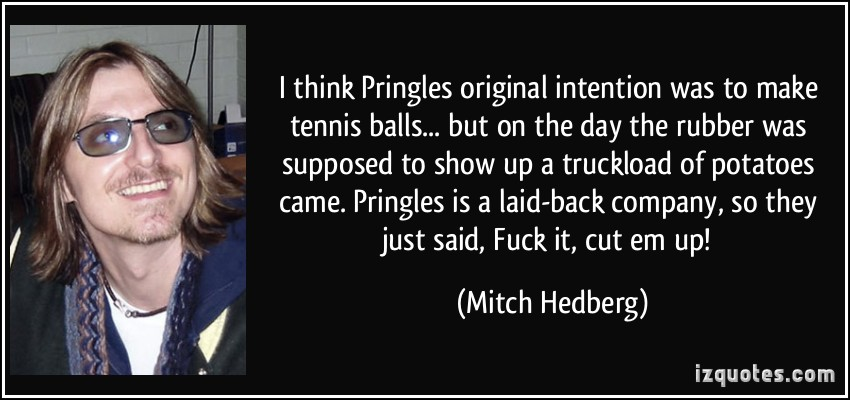

For these next steps of data preprocessing I believe the appropriate tools are available through scikit/learn preprocessing library with documentation [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

Inspecting the list at this link a few tools jump out at me. First even though we didn't find any missing values in our training set, it is still possible that there could be some in the test data, so one way to mitigate that effect is by inserting the mean of a range into the missing cell as can be accomplished with [preprocessing.Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html#sklearn.preprocessing.Imputer). Another tool that we will use is the [preprocessing.LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer) which will allow us to convert the CentralAir Y/N classifications to 0/1 numerical designation. With respect to normalization of numerical range columns, there is a good discussion of the different approaches in scikit learn documentation [here](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py), since I don't expect distributions to deviate significantly from gaussian distribution (which admittedly may be a naive assumption), am going to stick to the basic [preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) approach for converting to gaussian with 0 mean and unit variance. Finally, for the all important neighborhood column with textual classifications and high evident correlation as one would expect, am going to use the [preprocessing.OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) method.

Note that for the Imputer function, expect will need to be careful when dealing with columns where a majority of cells are missing values such as is the case in our full dataset for PoolQC, Fence, etc. - fortunately for our bare minimum approach we have scrubbed the columns where this might be an issue. Actually come to think of it am not sure how this function will behave while the dataframe still includes either text classifications or event transofrmations to sparse vectors, in both cases a mean and unit variance would be meaningless. So it may be the case that will need to explore alternate means to address missing cells in these type of features, will do a little explorations on that point. There appears to be a good blog post [here](http://machinelearningmastery.com/handle-missing-data-python/) which will review. One option is to remove rows with missing values but that's the easy way out and anyway once we graduate to an expanded dataset it won't serve us well.

Update: upon further exploration it appears it's possible to do some basic trnasformations without resorting to scikit learn. Pandas documentaiton has some good tutorials [here](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) - see this link's 'Cleaning / filling missing data' section for examples. 

So I'm going to attempt to address potential issues with missing vlues for each of the columns in our paired down data set. Note that we already established that this training set doesn't even have any missing values (if I am interpretting In[96] correctly), still we don't know for sure if our test data will be comparable and even though it seems unlikely I'm guessing it is good practice to address just in case.

*Nick from the future here, it turned out that this was a good decision.


In [21]:
#data preprocessing

#deal with missing values in textual columns

#replace missing neighborhood with a dummy variable
df_bm['Neighborhood'].fillna('fill')

#replace missing ac classification with Y since is more likely of the two 
#and allows us to maintain a binary classification
df_bm['CentralAir'].fillna('Y')

df_bm[:5]


Neighborhood  YearBuilt  OverallQual CentralAir  SalePrice  TotBathroom  \
0      CollgCr       2003            7          Y     208500          3.5   
1      Veenker       1976            6          Y     181500          2.5   
2      CollgCr       2001            7          Y     223500          3.5   
3      Crawfor       1915            7          Y     140000          2.0   
4      NoRidge       2000            8          Y     250000          3.5   

   TotSF  
0   2416  
1   2240  
2   2272  
3   1933  
4   2853

In [22]:

#deal with missing values in numerical columns using scikit learn Imputer

from sklearn.preprocessing import Imputer


imp = Imputer(missing_values='NaN', strategy='mean', axis=1)

#note for some reason following call requires a 2d array, 
#so using extra pair of breackets around df_bm['YearBuilt']
imp.fit([df_bm['YearBuilt']])
df_bm['YearBuilt'] = pd.Series(imp.transform([df_bm['YearBuilt']]).tolist()[0])

imp.fit([df_bm['OverallQual']])
df_bm['OverallQual'] = pd.Series(imp.transform([df_bm['OverallQual']]).tolist()[0])

imp.fit([df_bm['TotBathroom']])
df_bm['TotBathroom'] = pd.Series(imp.transform([df_bm['TotBathroom']]).tolist()[0])

imp.fit([df_bm['TotSF']])
df_bm['TotSF'] = pd.Series(imp.transform([df_bm['TotSF']]).tolist()[0])

df_bm[:5]

Neighborhood  YearBuilt  OverallQual CentralAir  SalePrice  TotBathroom  \
0      CollgCr     2003.0          7.0          Y     208500          3.5   
1      Veenker     1976.0          6.0          Y     181500          2.5   
2      CollgCr     2001.0          7.0          Y     223500          3.5   
3      Crawfor     1915.0          7.0          Y     140000          2.0   
4      NoRidge     2000.0          8.0          Y     250000          3.5   

    TotSF  
0  2416.0  
1  2240.0  
2  2272.0  
3  1933.0  
4  2853.0

Two comments on this Imputer transformation:
1) note that in process it transformed integer values to floats. My expectation is that this will not impact the regression.
2) Note that I left the SalePrice column untouched, as the output value I hope no normalization is required since we lose some information in the process and would then have to figure out how to switch test outputs back to original scale, hoping don't have to go there.

Ok now we finally get to transform the textual classifications, then after that we will normalize. Again we'll use OneHot Encoder for the neighborhood and binarizer for the central ac.

For the OneHot Encoder, there is a feature to autoselect the number of potential values based on the data which it defaults to, however I think would be prudent to enter this value manually in case we are missing some category in training set but not in test set (such as our dummy 'fill' category meant to address missing cells, for which we need to remember to add one count to the number of designated categories - actually on second thought even that won't work on its own since the onehotencoder only knows how to assign vector based on labels that it sees in the input data, so way I figure is that in order to properly encode here we would need to ensure that all potential values are represented in the training data, and if they aren't then assume we would need to enter additional dummy rows containing those values in training data prior to encoding - tell you what to ensure that the dummy fill value is present I'll just pick one data point and replace the Neighborhood value with our dummy 'fill' value - this will increase the length of our sparse vector from 25 to 26). We'll also need to convert each text category to a numerical id before applying the encoder, I'll be basing this on a demonstration from the hands on machine learning text chapter 2 notebook.

In [23]:
#encode the Neighborhood category to onehot sparse unitary vectors

#assign the dummy 'fill' Neighborhood value to one random row in data
#to ensure correct range of values for onehotencoding 
#(in case any missing values in test set)

from random import randint

if 'fill' not in df_bm['Neighborhood']:
    randomrow = randint(1, 1460)
    df_bm.set_value(randomrow,'Neighborhood','fill')
    print('replaced Neighborhood value for row ', randomrow, ' with "fill".')

replaced Neighborhood value for row  877  with "fill".


In [24]:
#transform text classifications to numerical id

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
nbrhd_cat = df_bm["Neighborhood"]
nbrhd_cat_encoded = encoder.fit_transform(nbrhd_cat)
nbrhd_cat_encoded

array([ 5, 24,  5, ...,  6, 12,  7])

In [25]:
#apply onehotencoding

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
nbrhd_cat_1hot = encoder.fit_transform(nbrhd_cat_encoded.reshape(-1,1))
nbrhd_cat_1hot

<1460x26 sparse matrix of type '<class 'numpy.float64'>'
	with 1460 stored elements in Compressed Sparse Row format>

In [26]:
#view encoded array
nbrhd_cat_1hot.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

note just saw that it is also possible to accomplish the two steps of transforming text to numerical id and then converting that list to sparse vector all in one shot using sklearn.preprocessing LabelBinarizer class, however the approach already recorded is working so not going to backtrack.

now that have gone through the trouble to encode, I'm a little confused as to how to combine this sparse matrix back with the dataframe object containing all the rest of our "bare minimum" training data for purposes of training... I'll going to set this question aside for now and hopefully will come accross answer as get deeper into tutorials. Perhaps is not neccesary that all training data is included in common dataframe object, to be continued...

Next we will perform the [preprocessing.LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer)  which will allow us to convert the CentralAir Y/N classifications to 0/1 numerical designation.

In [27]:
#convert central A/C to binary 0/1 classification

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
df_bm['CentralAir'] = lb.fit_transform(df_bm['CentralAir'])
df_bm['CentralAir'][:5]


0    1
1    1
2    1
3    1
4    1
Name: CentralAir, dtype: int64

Great so next step of our data preprocessing activities on the bare minimum set is to normalize the remaining columns again using the [preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) approach for converting to gaussian with 0 mean and unit variance (aka 'feature scaling').

As an aside, one point I'm a little unclear on is whether its best practice to perform data preprocessing transformations directly on the original dataframe object or whether each transformation should create a whole new column which we'll just have to keep track of. I can see benefits of both approaches.

Another consideration for preprocessing, hands on ml text suggested using the sklearn.pipeline class to combine sequences of transformations into single function. That could be one way to improve this process in future iterations. As we get into larger datasets (such as the full 81 for this problem as presented), I could definitely see the value of such a pipline function.

Found a stack overflow tutorial on performing feature scaling in place on select coloumns in a dataframe object, can view source [here](https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn). Note that this is another case where extra brackets are required, I think this is because the feature needs a 2D array as input for some reason (?), it's not exactly intuitive to include those brackets for whatever it's worth.

In [28]:
#normalize remaining columns using standard scalar approach (feature scaling)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_bm[['YearBuilt','OverallQual','TotBathroom','TotSF']] \
= scaler.fit_transform(df_bm[['YearBuilt','OverallQual','TotBathroom','TotSF']])

#view transformed set
df_bm[:5]


Neighborhood  YearBuilt  OverallQual  CentralAir  SalePrice  TotBathroom  \
0      CollgCr   1.050994     0.651479           1     208500     1.642256   
1      Veenker   0.156734    -0.071836           1     181500     0.368581   
2      CollgCr   0.984752     0.651479           1     223500     1.642256   
3      Crawfor  -1.863632     0.651479           1     140000    -0.268257   
4      NoRidge   0.951632     1.374795           1     250000     1.642256   

      TotSF  
0  0.529516  
1  0.302404  
2  0.343697  
3 -0.093752  
4  1.093426

Ok reviewing the remaining data, note that this set still includes the textual classifications for Neighborhood, the encoded vectors are in a seperate object celled "nbrhd_cat_1hot". I'm hoping the fact that is in seperate object won't be an issue when it comes to training, will cross that bridge when we get there, for now I'll go ahead and delete the original Neighborhood column from the set. (before doing so will save the data to a seperate list just in case we need it again at some point (fearing ominous foreshadowing here (*NFTF here, this fear was unfounded)).)

In [29]:
#back up the Neighborhood column
nbrhd_text = df_bm['Neighborhood']

#delete Neighborhood text classifications column
del df_bm['Neighborhood']

#view remaing features (other than neighborhood vectors which are stored seperately)
df_bm[:5]


YearBuilt  OverallQual  CentralAir  SalePrice  TotBathroom     TotSF
0   1.050994     0.651479           1     208500     1.642256  0.529516
1   0.156734    -0.071836           1     181500     0.368581  0.302404
2   0.984752     0.651479           1     223500     1.642256  0.343697
3  -1.863632     0.651479           1     140000    -0.268257 -0.093752
4   0.951632     1.374795           1     250000     1.642256  1.093426

A thought: I'm maybe overcomplicating the onehot encoding by keeping it as a seperate set, perhaps it's just as simple as adding these 26 columns to our training dataframe. While not sure if this will be a "sparse" representation memory-wise where computer only has to store values for cells with non-zero values, for datasets of our scale that would hardly be a concern, M chip or otherwise. So yeah after talking it through I think it is easier than had originally supposed. So here goes going to try and add these 26 columns to our dataframe.

First note that we already have some of the data I think we'll need. The column labels are extracted in array "nbrhd_cat" which are then encoded into numerical id's in array "nbrhd_cat_encoded", and then were finally transformed into sparse matrix in object "nbrhd_cat_1hot" (which can then be viewed as an array via nbrhd_cat_1hot.toarray(). So in order to join the sparse array to the test data which is a pandas dataframe object we'll first have to convert from the numpy array to a pandas dataframe, and then we can concatinate to combine the two - important to keep in mind that we haven't done any sorting of our data so features for both sets should still be in same order. I'll just name the columns for the sparse array with integers [1,27], hopefully it won't be an issue they they are labeled with integers instead of strings, will have to keep that in mind when it comes time to call any of these columns.

In [30]:
#convert Neighborhoods sparse array to pandas dataframe with column labels 1-26)
df_nbrhd = pd.DataFrame(nbrhd_cat_1hot.toarray(), columns=range(1,27))

#concatinate the sparse neighborhood set with the rest of our training data
df_bm = pd.concat([df_nbrhd, df_bm], axis=1)
df_bm[:5]


1    2    3    4    5    6    7    8    9   10    ...      23   24   25  \
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0    ...     0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0    ...     0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0    ...     0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0  0.0   

    26  YearBuilt  OverallQual  CentralAir  SalePrice  TotBathroom     TotSF  
0  0.0   1.050994     0.651479           1     208500     1.642256  0.529516  
1  0.0   0.156734    -0.071836           1     181500     0.368581  0.302404  
2  0.0   0.984752     0.651479           1     223500     1.642256  0.343697  
3  0.0  -1.863632     0.651479           1     140000    -0.268257 -0.093752  
4  0.0   0.951632     1.374795           1     250000     1.642256  1.093426  

[5 rows x 32 columns]

One last task for data preprocessing. I believe that when it comes time to actually run the training we'll want our features and labels (aka sales price) sorted into seperate objects, x_train and y_train. So let's quickly create those two sets.

In [31]:
#create training sets of features x_train and labels (sales price) y_train

#x_train is the training set excluding sale price
x_train = df_bm.drop(['SalePrice'], axis=1)
#y_train is sale price
y_train = df_bm['SalePrice']


So while I'm tempted to say we are done with data preprocessing, it occurs to me that there are a few additional steps we have missed, 1) all of this processing that was done to our training set we're going to have to do all over again for our test set and 2) we're going to have to break the training and label sets into two pieces (one for training, one for validation). Boy this data preprocessing is just the gift that keeps on giving. I think we'll tackle number 2 first..

Ideally when you break out the validation set from training samples you would want a random sampling of rows from the set in case there was any bias in order data was collected (for example with home sales data one could imagine a scenario where data was collected in chronological order of home sale although that's not the actual case here). At first was going to take lazy route and just assume the data was already randomly distributed in test set, however just found that sklearn has a method for breaking complementary x,y sets into coresponding random split sets based on the same seeding for randomness. It's called train_test_split, however I don't see any reason we can't adopt the tool for a train validation split. More on approach [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

As for the size of the training vs validation sets, going by memory I think I've seen some different rules of thumb thrown around for portion that should be applied to validation ranging from 15% to 30% (again this is by memory so may be off), I'm going to arbitraily asign 20% to validation, so the training set size will be 1460 * 0.8 = 1168, and validation will be 1460 - 1168 = 292.

Note that before splitting the training data will first make a copy of the full set in case we later want to attempt K-fold validation after our initial training run (we will).

In [32]:
#create a copy fo the full training set 
#in case is later needed such as for K-fold validation

x_train_full = x_train
y_train_full = y_train

#seperate training sets of features (x) and labels (y)
#into two pieces for training and validation 

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = \
train_test_split(x_train, y_train, test_size=0.20, random_state=42)


Ok this next bit of code is going to be a bit longer than what we've tackled so far, but it's just repeat and slight reshuffling of what has already been covered. The goal here is to take our test data set (which Kaggle provided in a seperate file) and perform all (ok most) of the same preprocessing transformations so as to derive a set called x_test. Note that this process will be slightly reduced in that it won't we won't bother with all of the explorations, we won't have the sales price column to work with, and finally we won't need to split this into test / validation like we did for the test set. Before we start let's quickly upload the file and confirm it's set up as we expected (as before we'll need to ensure that our data file is saved in same folder as this notebook otherwise we would need to redirect the path). This inspection could parallel be performed in rapidminer again if so inclined.

In [33]:
#inspect test set
df_test = pd.read_csv("test.csv") 
#df_test[:5]
df_test.shape

(1459, 80)

As expected this set has one fewer column since the sale price is not included (this is the feature we're trying to predict after all) - oh and apparently one fewer row which doesn't seem important. I brought the following up earlier and am still a little unsure about this point: when we were preparing our train set we scrubbed the Id number column so as not to interfere with the training operation, I'm hoping the Id number isn't used for some type of Kaggle submission validition, will have to find a tutorial. For now will assume it is not. (Update: the id number is in fact used for Kaggle submission, however will for now intend to take the approach of adding the id number back to the predictions set after applying our machine learning magic, after all I don't see why we would be shuffling the test set at any point so don't expect that will be a problem.)

Ok here comes the fun part, going to revisit all of our prior transformations to the test set. As mentioned prior this part would probably have been alittle easier to assemble if we had used the sklearn.pipeline class instead of performing transformations one at a time, but you know as my prominent lower back tattoo says in an elaborate and poetic font: No Regerts.


In [34]:
#data preprocessing for test set

#open test file
df_test = pd.read_csv("test.csv") 

#create set of labels we'll need for Kaggel submission
labels_test = df_test['Id']

#reduce to 'bare minimum' features
df_test = df_test.loc[:,['Neighborhood','GrLivArea','YearBuilt','OverallQual','CentralAir','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtUnfSF']]

#Create total bathroom count TotBathroom
#TotBathroom = FullBath + (0.5) * HalfBath + BsmtFullBath + (0.5) * BsmtHalfBath
TotBathroom = df_test.FullBath + 0.5 * df_test.HalfBath \
+ df_test.BsmtFullBath + (0.5) * df_test.BsmtHalfBath

#add column to data set
df_test['TotBathroom'] = TotBathroom

#remove columns we don't need anymore
del df_test['FullBath']
del df_test['HalfBath']
del df_test['BsmtFullBath']
del df_test['BsmtHalfBath']

#Create total square foot TotSF
#TotSF = GrLivArea + TotalBsmtSF - BsmtUnfSF
TotSF = df_test.GrLivArea + df_test.TotalBsmtSF - df_test.BsmtUnfSF

#add column to data set
df_test['TotSF'] = TotSF

#remove columns we don't need anymore
del df_test['GrLivArea']
del df_test['TotalBsmtSF']
del df_test['BsmtUnfSF']

#deal with missing values in textual columns

#replace missing neighborhood with a dummy variable
df_test['Neighborhood'].fillna('fill')

#replace missing ac classification with Y since is more likely of the two 
#and allows us to maintain a binary classification
df_test['CentralAir'].fillna('Y')


#deal with missing values in numerical columns using scikit learn Imputer

from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=1)

#note for some reason following call requires a 2d array, 
#so using extra pair of breackets around df_bm['YearBuilt']
imp.fit([df_test['YearBuilt']])
df_test['YearBuilt'] = pd.Series(imp.transform([df_test['YearBuilt']]).tolist()[0])

imp.fit([df_test['OverallQual']])
df_test['OverallQual'] = pd.Series(imp.transform([df_test['OverallQual']]).tolist()[0])

imp.fit([df_test['TotBathroom']])
df_test['TotBathroom'] = pd.Series(imp.transform([df_test['TotBathroom']]).tolist()[0])

imp.fit([df_test['TotSF']])
df_test['TotSF'] = pd.Series(imp.transform([df_test['TotSF']]).tolist()[0])


#encode the Neighborhood category to onehot sparse unitary vectors

#assign the dummy 'fill' Neighborhood value to one random row in data
#to ensure correct range of values for onehotencoding 
#(in case any missing values in test set)

from random import randint

if 'fill' not in df_test['Neighborhood']:
    randomrow = randint(1, 1459)
    df_test.set_value(randomrow,'Neighborhood','fill')
    #print('replaced Neighborhood value for row ', randomrow, ' with "fill".')

    
#transform text classifications to numerical id

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
nbrhd_cat = df_test["Neighborhood"]
nbrhd_cat_encoded = encoder.fit_transform(nbrhd_cat)

#apply onehotencoding

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
nbrhd_cat_1hot = encoder.fit_transform(nbrhd_cat_encoded.reshape(-1,1))


#convert central A/C to binary 0/1 classification

from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
df_test['CentralAir'] = lb.fit_transform(df_test['CentralAir'])
df_test['CentralAir'][:5]


#normalize remaining columns using standard scalar approach (feature scaling)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_test[['YearBuilt','OverallQual','TotBathroom','TotSF']] \
= scaler.fit_transform(df_test[['YearBuilt','OverallQual','TotBathroom','TotSF']])

#back up the Neighborhood column
nbrhd_text = df_test['Neighborhood']

#delete Neighborhood text classifications column
del df_test['Neighborhood']


#convert Neighborhoods sparse array to pandas dataframe with column labels 1-26)
df_nbrhd = pd.DataFrame(nbrhd_cat_1hot.toarray(), columns=range(1,27))

#concatinate the sparse neighborhood set with the rest of our training data
df_test = pd.concat([df_nbrhd, df_test], axis=1)


#create test sets of features x_test

#x_test is the training set
x_test = df_test

#labels_test already created as labels for Kaggle submission


x_test[:5]




1    2    3    4    5    6    7    8    9   10    ...      22   23   24  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0    ...     0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0    ...     0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  1.0  0.0   

    25   26  YearBuilt  OverallQual  CentralAir  TotBathroom     TotSF  
0  0.0  0.0  -0.340945    -0.751101           1    -1.476827 -0.631311  
1  0.0  0.0  -0.439695    -0.054877           1    -0.874606  0.367459  
2  0.0  0.0   0.844059    -0.751101           1     0.329837  0.592988  
3  0.0  0.0   0.876976    -0.054877           1     0.329837  0.305707  
4  0.0  0.0   0.679475     1.337571           1    -0.272384 -0.584326  

[5 rows x 31 columns]

Now that we have our test set, just to ensure that we have equivalent structure of features, lets quickly pull up our x_train and compare.

In [35]:
x_train[:5]

1    2    3    4    5    6    7    8    9   10    ...      22   23  \
254   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0   
1066  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0    ...     0.0  0.0   
638   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0    ...     0.0  0.0   
799   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0   
380   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    ...     0.0  0.0   

       24   25   26  YearBuilt  OverallQual  CentralAir  TotBathroom     TotSF  
254   0.0  0.0  0.0  -0.472560    -0.795151           1    -0.268257  0.297243  
1066  0.0  0.0  0.0   0.719786    -0.071836           1     0.368581 -0.560881  
638   0.0  0.0  0.0  -2.029235    -0.795151           1    -1.541932 -1.560949  
799   0.0  0.0  0.0  -1.134975    -0.795151           1     0.368581  0.427574  
380   0.0  0.0  0.0  -1.565545    -0.795151           1    -0.268257 -0.124722  

[5 rows x 31 columns]

So unless I'm mistaken we have completed our data preprocessing journey. We started with a training dataset which we converted to x_train, y_train, x_val, and y_val; we kept a copy of the full test set under x_train_full and y_train_full; and we also started with a test set which we converted in similar fashion to x_test  and labels_test. Was a lot of code at once in this test set processing, the hardest part was dealing with a bug in the Imputer call (I had originally used axis=0 instead of axis=1 which to be honest am not entirely clear on what this is specifying but the code is working now so no complaints). Now I do believe are ready to transition to the fun stuff, training. I'm going to celebrate by staring at my phone for a few hours until I get tired, see you in the morning :).

# Part 2: Training

So we have our training and validation data, now what do we do with it? This home price prediction question is a regression problem (not to be confused with a logistic regression problem which is in fact a poorly named type of classification problem but I digress). While in the first part of this notebook I kind of used a whole slew of different sources, tutorials, books, etc as reference, I suspect the source material for these training operations will be a bit more condensed. Chollet has a section in Deep Learning with Python devoted to sample Keras training code for not only this type of problem but also this specific application for predicting house prices (section 3.8) - the primary difference between his example and what we're trying to accomplish here is a) our 26 sparse columns and b) his example has less training data (which he addresses by turning to k-fold validation to make use of as much of the training data as he can). Although we have a little more data (around 1,400 samples vs I think he desccribed as around 500), it still seems like would be good practice to attempt the k-fold approach. So even though one would think that starting our model with a k-foild validation technique would deviate from our stated intent of starting with a minimum viable model, the fact that we have sample code right on hand from the text suggests this might be the easier of two paths, so yeah the decision is to just jump straight into k-fold instead of developing simpler model to start.

Since am leaning heavily on this text, I'll just point out that recently submitted a [review](https://www.goodreads.com/review/show/2068748621?book_show_action=false&from_review_page=1) on Goodreads. Just like Keras pairs down neural network modelling to it's most essential modeling elements for clarity and simplicity, the prose in this book is comparable and I highly recomend.

So at this point will switch from an Anaconda based jupyter notebook to running this set on my AWS EC2 AMI virtual machine really for two reasons: 1) my laptop is underpowered and not sure how it will take to training operations 2) I am sort of embarrasingly undercomplished in admittedly very simple operations such as installing platforms like Keras - it literally and embarrasingly took me like two weeks to install Tensorflow although in my defense Google buries the instructions for Anaconda install - so yeah these virtual machines have all fo those environments preloaded so yeah path of least resistence and whatnot.

Ok well logging out and will be right back - in the cloud!

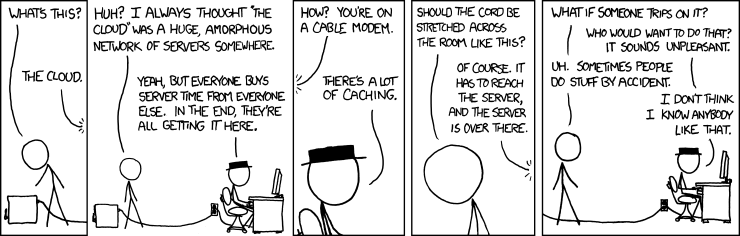

Ok so before constructing our model based on Chollet's demo, a few notes about some of the assumptions going in:
- the models.Sequential() category is typical for types of models a beginner will be working with, so won't go into depth on this point (a researcher may venture into the functional API for customizations beyond standard approaches)
- our first (and only) hidden layer was demonstrated in the the test as 64 hidden units. Since we have a few more features in our training data I'm going to tap it up a notch to 70, this adjustment is very arbitrary though, the depth of this hidden layers will be one of our hyperparameters
- the hidden layer will be densely connected and euse relu activation units, this is not an unusal approach *however note that the hands on ml text has some interesting discussion about potential improvements to the relu activation (spoiler from memory I believe they smooth out the transition point to make it differentiable at x=0 and slightly offset from value of y=0). One more relu tangent, worth noting that although one of the big catalysts for the current deep learning renaisance was the discovery by Geoffrey Hinton et al that deep learning networks could be pre-trained using unsupervised learning algorithms, it was largely the advent of the relu activation units that allowed us to move to exlcusive supervised training of deep netowrks ([source](https://stats.stackexchange.com/questions/163600/pre-training-in-deep-convolutional-neural-network/186168#186168))
- the output layer will have 1 unit densely connected which will output our house price
- I believe mse (mean squared error) loss function is usually preferred over cross entropy for regression problems, although in other use cases I tend to come accross cross entropy more often, some disucssion about tradeoffs on quora [here](https://www.quora.com/When-should-mean-squared-error-be-preferred-over-average-cross-entropy-for-a-loss-function).
- mae (mean average error) is our validation metric that we will use to gauge progression of training over the epochs. I'm not sure if is a problem that this doesn't exactly matches the evaluation metric from the Kaggle competition of root mean square error, ideally I'm thinking we would want our validation metric to match our evaluation metric I suppose, but am sort of struggling at navigating the Keras documentation on this point, both approaches are measure the same error so hopefully won't hurt my cause to use slightly different metric in validation.
- for the optimizer I'm just going to defer to the text recomendation of rmsprop, for those wishing to experiment there's a good discussion of some different optimization approaches and their merits [here](http://ruder.io/optimizing-gradient-descent/index.html#whichoptimizertochoose) although treatment of some next generation methods is omitted.
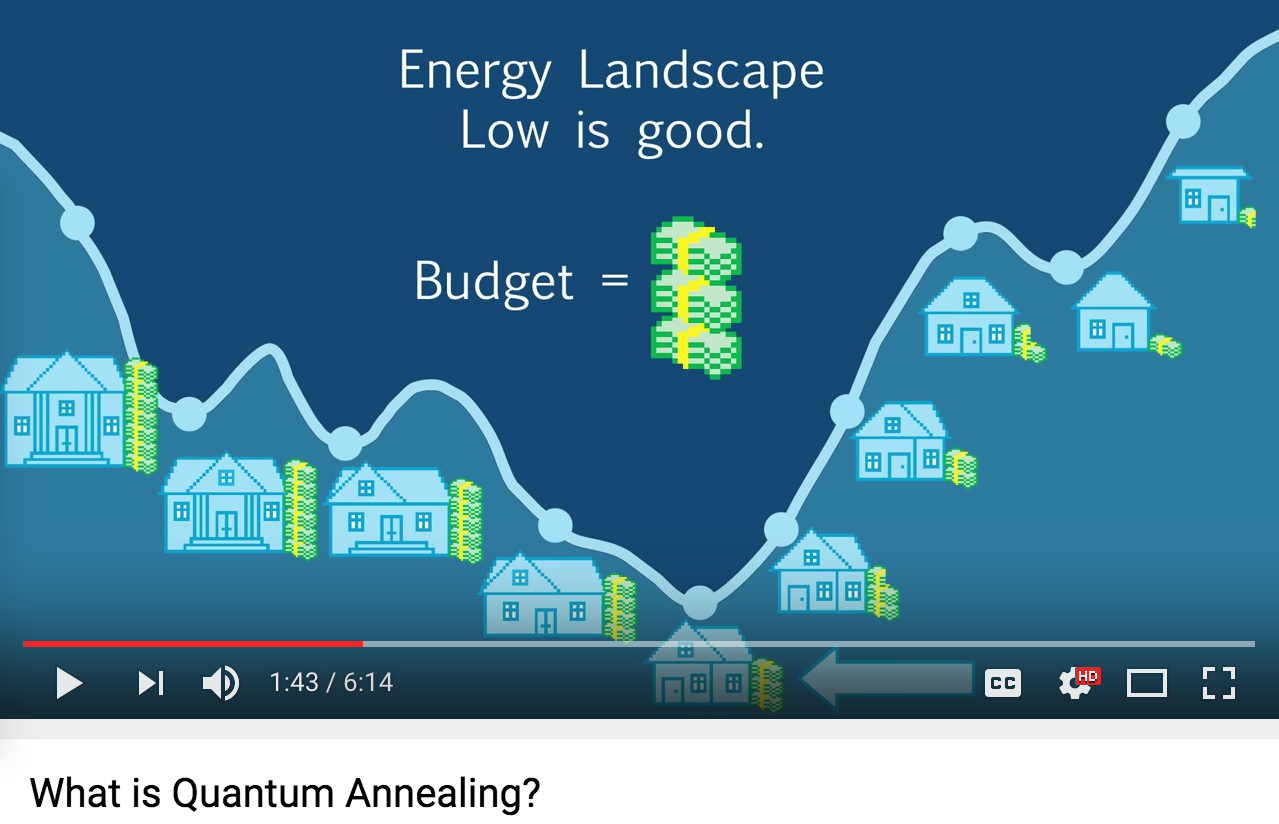



In [36]:
#Keras imports
from keras import models
from keras import layers


#define our model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(70, activation='relu', input_shape=(x_train_full.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model



Using TensorFlow backend.


Ok next we're going to assemble code for hte K-fold approach to validation. For those less initiated k-fold is useful approach when have limited training data, which could cause our validation metric to be highly impacted by randomness of selection of data points. The k-fold approach splits the data into k sets, each with a mutually exclusive valdidation partition, training is performed simuilatneously on each of these folds with validation metric calculated, and then the valdidation metric accross the three sets is averaged to determine the overall validation metric for each epoch. Note that higher number of folds will increase our training time. Chollet used four folds for his 500 training data points, as we have around 1500 I'll arbitrarily bump up the number of folds to 5. We could increase this even more, have seen some suggest that even ten folds is not unusual, however that would also increase our training time so let's start small and see how it goes. (Thus the k number of folds could be another hyperparameter if we so desired).

The following code is basically verbatim from deep learning with python text except I will use my terms for the training data (x_train_full) and targets (y_train_full). Will start with 100 epochs as used in the text. One thing I learned as part of this process is that Keras requires data and labels in form of numpy arrays, since ours are currently saved as pandas dataframes will start here by converting.


In [37]:
#convert data and labels from pandas dataframe to numpy array
x_train_full_np = x_train_full.values
y_train_full_np = y_train_full.values
x_test_np = x_test.values

In [34]:
# WARNING: unless you have a GPU this code may take a while to run

#set up K-fold validation

#k = number of folds
k = 5
num_val_samples = len(x_train_full_np) // k
all_scores = []
for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition #k
    val_data = x_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train_full_np[:i * num_val_samples],
         x_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_full_np[:i * num_val_samples],
         y_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    
    # train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets, epochs=100, batch_size=1, verbose=0)
    
    # evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


So got this to run after fixibng a few typos and figuring out the issue with dataframe vs numpy array. Also I tried running a single epoch just to get an idea of how long it would take to process on this micro instance, turned out was through the epoch in less than 10 seconds, so figure 100 epochs will take somewhere around 10 minutes, so I think am going to remain in this micro instance instead of transitioning to one with a GPU - partly because I'm cheap and partly because AWS makes it ridiculously hard to upgrade from their free tier so you can access GPU instances(turns out you have to initiate a service request and interact with an agent to enable access to AWS GPU instances, and then takes a day or two to process the request).

In [35]:
# view validation mae for each of the five k folds resulting after 100 epochs
all_scores

[26837.145601455479,
 27607.042005565068,
 28460.128157106163,
 25405.348833476026,
 28536.413687928081]

In [36]:
# view average validation mae for each  of the five k folds resulting after 100 epochs
np.mean(all_scores)

27369.215657106164

In [38]:
#compare error values to distribution of the y labels
y_train_full.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

So comparing our mean average error to the mean of our trainign labels you see we have an average error of +/- 15%. Pulling up the Kaggle leader board 1100th place out of around 1500 entries. Top performance has error rate of 6.6% by user DSXL (who is dramatically far ahead of second place BTW, while second place has achieved 10.6% with much denser progression through rest of leader board - after getting through this write-up going to do a little digging if first place has published any hints of how they have ahcieved such dramatic improvements over the rest of the pack). 

On it's own I think achieving top 1,000 of a popular Kaggle introductory competition on my very first machine learning algorithm is kind of cool, however this is a validation score and not a test score so let's not get too far ahead of ourselves. Still have some hyperparameter optimization to perform.

One thing worth note, the range of error rates between the sperate k folds was much more dramatic in the text example than we are seeing here under all_scores array. I'm guessing that's because of the increase number of training samples in our data, should not surprise that there is a big difference between the impact of randomness in fold distribution between 500 and 1500 data points. There's a good illustration from Wolfram's [A New Kind of Science](http://www.wolframscience.com/nks/) (page [328](http://www.wolframscience.com/nks/p328--the-phenomenon-of-continuity/)) of the impact of increasing data points by orders of magnitude to the clean distribution of data sampled from a random walk that comes to mind.

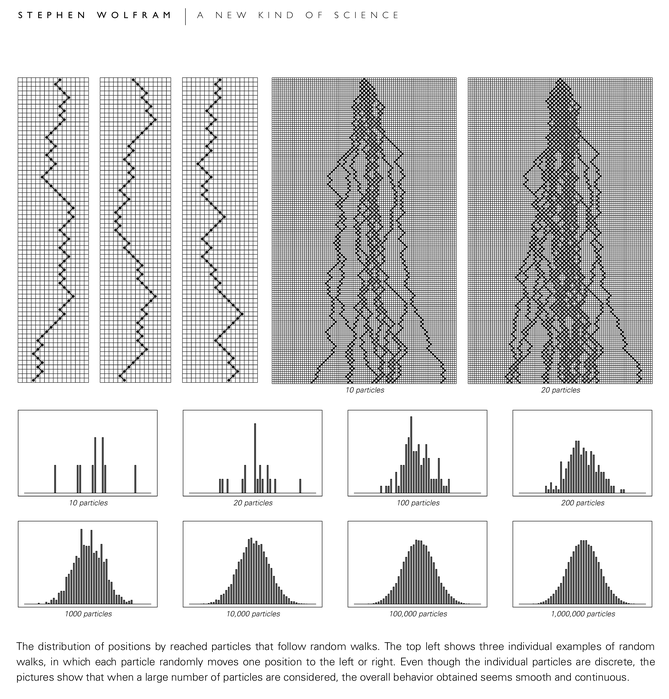

The next step that text example suggests is charting the progression of the mae metric accross  epochs while also upping he number of training epochs. To do so I'm going to repeat the K-fold code from above but with addition of a variable for number of epochs and then all of the various mae history materials from the text example Listing 3.91 (there are a few subtle differences from last training run I won't try to list them all), which once complete with the training run we will illustrate in a chart. 

At the expectation that increasing the epochs to 500 as suggested in the text will go against my proclivity for not sitting on my hands for more than an hour at a time, I'll pair down the suggested epochs to 300 and also lower the number of k-folds to 3 - after all as we demonstrated in first attempt the difference of validatino metrics between folds has not been as dramatic for this set as what was demonstrated in the text. These two concessions should help reduce training time. 

Warning: running this code will take even longer to complete than the last iteration so may sure you have the time or a GPU before pressing play.

In [38]:
# WARNING: this code will take a while to run without a GPU


#repeat K-fold evaluation but with improved validation tracking accross epochs

#adjustments to hyperparameters: epoch = 300, k = 3, hidden row = 70

#define our model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(70, activation='relu', input_shape=(x_train_full.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


#k = number of folds
k = 3

# number of epochs
num_epochs = 300

num_val_samples = len(x_train_full_np) // k

#new array
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition #k
    val_data = x_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train_full_np[:i * num_val_samples],
         x_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_full_np[:i * num_val_samples],
         y_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    
    # train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    #following is all new code
    
    #log the mae histories accross epochs
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    #compute the average of the per-epoch MAE score for all folds
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print('training complete')

processing fold # 0
processing fold # 1
processing fold # 2
training complete


Don't forget to save your trained model for later imports - otherwise the last 2-1/2 hours could go to waste!

Keras documentation on exporting and importing trained models [here](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model).

In [39]:
#save trained model
model.save('housing_model_8-13-17.h5')


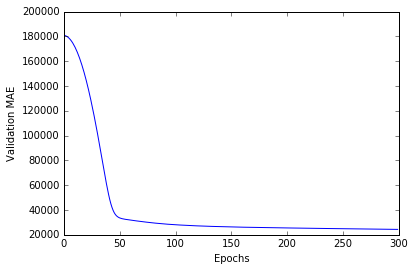

In [40]:
#plot the validation progression accross epochs
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

Occurs to me that it might be easier to eyeball the training improvement of later epochs if we change scale on the y axis to log plot so let's give that a try.

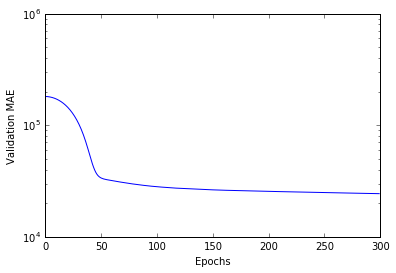

In [48]:
#plot the validation progression accross epochs
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), average_mae_history)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [42]:
#View final validation metric
print('the final validation metric was', average_mae_history[-1:])

the final validation metric was [24357.337717817642]


So after 300 epochs, the final validation metric (mean average error) was 24.3k, which is an improvement over our initial 100 epoch run that came in with a score of about 27k. So increasing the number of epochs helped. 

Note that the type of visualization performed here can also be accomplished with Tensorboard which is a browser based model and validation evaluation tool that is a part of Tensorflow. Which probably should have pointed out earlier that even though we are running this model through the Keras framework, that implementation is merely a front end for (our coice of) Tensorflow, Theano, etc. Thus if you wanted to monitor your model with Tensorboard I do believe it is possible as long as you are directing Keras to implement Tensorflow for its backend (which I believe it defaults to).

For our next step, we can attempt to tune some hyperparameters, keeping in mind that there must be a balance between improving our model's accuracy and preventing overfit. Most of the more advanced problems out in the wild will have a whole slew of parameters to deal with, one great thing about this simple problem is that the single hidden layer architecture and established industry norms for addressing regression problems means that we won't need to venture too far from our current model architecture. The text suggests playing with number of epochs and the size of the hidden layer. If we were feeling really adventurous we could experiment with some other features such as trying a different optimization algorithm (such as Adadelta), experimenting more with the number of k folds, add another hidden layer, or who knows maybe even incorproate dropout into the training (although truth be told I'm not sure if that's appropriate for such a shallow model). For the more advanced problems there are even some tools out there to automate the hyperparameter exploration process. Chollet mentions a Python library called [Hyperopt](https://github.com/hyperopt/hyperopt) in the text which can explore feature spaces using Random Search or something called Tree of Parzen Estimators (you know a concept is on the cutting edge when there doesn't even exist a wikipedia entry for it - would someone mind getting on that?:) - a Keras wrapper for this tool can be found on github [here](https://github.com/maxpumperla/hyperas). There is even experimentation going on at [OpenAI](https://gym.openai.com/envs#parameter_tuning) to automate hyperparameter search using reinforcement learning algorithms!


If our last derivation of Kaggle score is to be believed, this run would have taken us from around 1,000th place on the leaderboard to somewhere around 700th place. Which is nice I suppose, putting us around the midpoint of competitors - all without a GPU no less. A 'C' is a passing grade after all! But figure I've got two more runs in me before wrapping this up, and will try to use those to experiment with size of the hidden row. This last training run was enjoyable - used the time to watch the movie Contact with Jodie Foster et al. Who knows maybe lurking somewhere in that cosmic background radiation there is an alien intelligence trying to be heard - I bet it could place very high on the leaderboard! You know (spoiler alert) when that pod dropped through the $300B alien device it only lost communication for a fraction of a second - but for Jodie something like 18 hours transpired - that technology could come in really handy for shortening training time of deep networks! Anyway I'll throw together another training run now and let it run overnight.
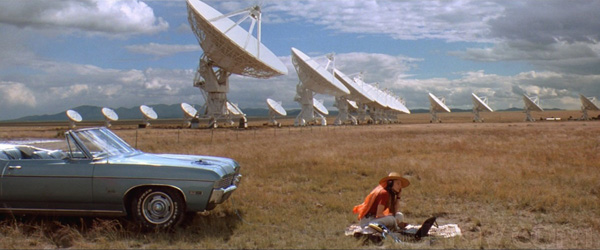

In [51]:
# WARNING: this code will take a while to run without a GPU


#repeat K-fold evaluation but with improved validation tracking accross epochs

#adjustments to hyperparameters: epoch = 300, k = 3, hidden row = 55

#define our model
#update hidden row to 55
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(55, activation='relu', input_shape=(x_train_full.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


#k = number of folds
k = 3

# number of epochs
num_epochs = 300

num_val_samples = len(x_train_full_np) // k

#new array
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition #k
    val_data = x_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train_full_np[:i * num_val_samples],
         x_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_full_np[:i * num_val_samples],
         y_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    
    # train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    #following is all new code
    
    #log the mae histories accross epochs
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    #compute the average of the per-epoch MAE score for all folds
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print('training complete')

processing fold # 0
processing fold # 1
processing fold # 2
training complete


In [53]:
#save trained model
model.save('housing_model_8-14-17_r1.h5')

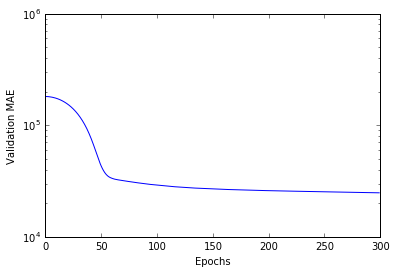

In [54]:
#plot the validation progression accross epochs
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), average_mae_history)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [52]:
#View final validation metric
print('the final validation metric was', average_mae_history[-1:])

the final validation metric was [24785.041846171982]


So by reducing the units in the hidden layer from 70 to 55 with 3 k-folds and 300 epochs the mean average error validation metric increased from 24.3k to 24.8k (meaning our model performed worse with same number of epochs). Since my expectation is that an architecture with fewer weightings should be able to reach performance in fewer number of epochs (not positive on this point though), I'm interpretting as our architecture does not have sufficient complexity to handle our evaluation. I'll try again, but this time moving the hidden layer units in oppositre direction, from 70 to 85. This will probably be our last hyperparameter optimization attempt - and depending on result will either finalize model based on the higher number of units or revert back to the 70 unit depth. For next Kaggle problem set I tackle will certainly incorporate a GPU and automoate the hyperparameter search. 

Once we settle on our architecture, we'll transition to the final task of preparing our Kaggel submission data which hopefully will be relatively straight forward.

In [55]:
# WARNING: this code will take a while to run without a GPU


#repeat K-fold evaluation but with improved validation tracking accross epochs

#adjustments to hyperparameters: epoch = 300, k = 3, hidden row = 85

#define our model
#update hidden row to 85
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(85, activation='relu', input_shape=(x_train_full.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


#k = number of folds
k = 3

# number of epochs
num_epochs = 300

num_val_samples = len(x_train_full_np) // k

#new array
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition #k
    val_data = x_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train_full_np[:i * num_val_samples],
         x_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_full_np[:i * num_val_samples],
         y_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    
    # train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    #following is all new code
    
    #log the mae histories accross epochs
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    #compute the average of the per-epoch MAE score for all folds
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print('training complete')

processing fold # 0
processing fold # 1
processing fold # 2
training complete


In [56]:
#save trained model
model.save('housing_model_8-14-17_r2.h5')

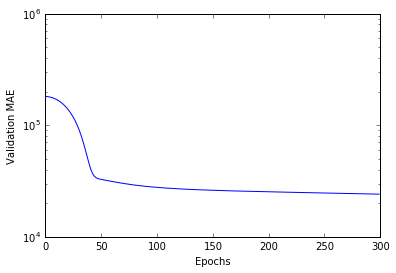

In [57]:
#plot the validation progression accross epochs
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), average_mae_history)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [58]:
#View final validation metric
print('the final validation metric was', average_mae_history[-1:])

the final validation metric was [24111.157309617196]


Eureka, we have found an improvement to our validation metric from increasing our number of hidden layer units from 70 to 85. A reasonable next step would be to step up our number of units and try again (or even better pick some new random combination of perterbations within our hyperparameter search sphere rinse lather and repeat), reason was never my strong suit however so am goin to consider this model official optimized. After all the goal was always minimal viable model, and given expected leaderboard placement from this validation score I do consider this viable. Now we need to apply our trained model for feature extraction from our test set, at which point we can prep for and submit to Kaggle to get our score. The finnish line is right around the corner!

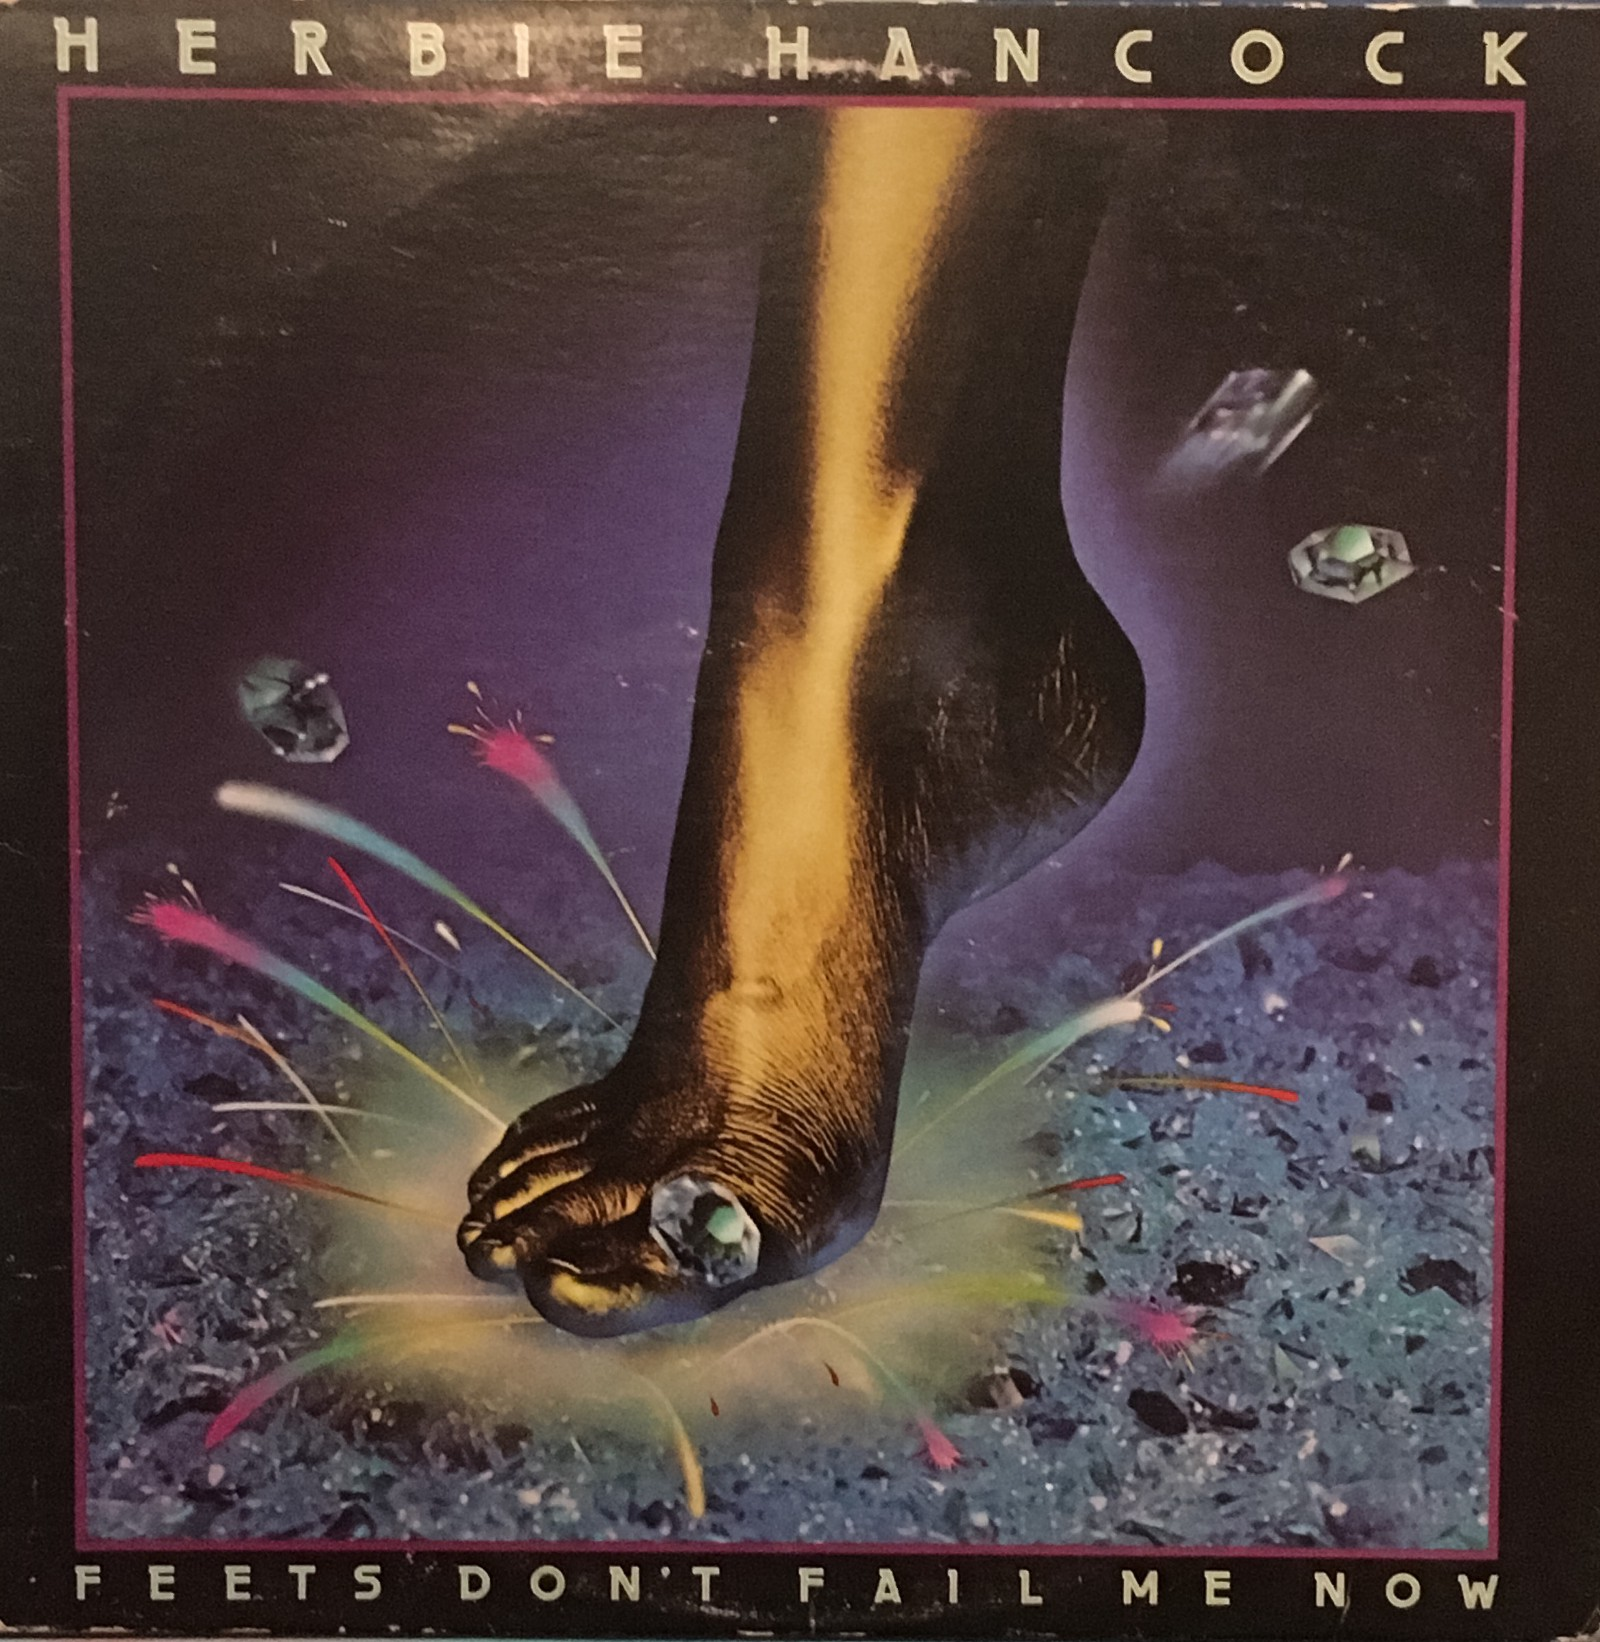

So here we'll apply our trained model to our test set and generate predictions. Even though our trained final model is already available in memory, I'll go ahead and upload the trained model we saved after the last run for demonstration purposes. Note that we could upload any of the different saved models at this point, I'll stick to the final one since it gave the best validation metrics. Just because I'm chicken and don't want to lose the trained model currently in memory in case of bug, am going to name the final model something different.

In [61]:
from keras.models import load_model

# returns a compiled model from prior saved architecture and weightings
modelf = load_model('housing_model_8-14-17_r2.h5')


And now for the application of our uploaded model to the test data. Cross your fingers!

In [62]:
# apply uploaded model to extract prediuctions from test data
results = modelf.predict(x_test_np)
results

array([[ 120423.96875  ],
       [ 176594.359375 ],
       [ 182814.40625  ],
       ..., 
       [ 161812.65625  ],
       [ 117640.5078125],
       [ 232697.6875   ]], dtype=float32)

In [63]:
# confirm we have the right number of values
results.size

1459

Ok we are closer than ever. Now reviewing the Kaggle submission requirements it appears they want the data in format of a comma seperated csv file, with headers on the columns, the ID numbers in first column, and test predictions in the second. I think to achieve that will convert the results array to a dataframe with header, merge the the ID dataframe, and then export to CSV. I'm guessing there are probably scripts developed by other competitors that could simplify this process but will save that exploration for next time.

In [72]:
#convert results array to pandas dataframe with column label
results_df = pd.DataFrame(results, columns=['SalePrice'])
#results_df[:5]

# concatinate the id labels column with the rest of our training data
submission = pd.concat([labels_test, results_df], axis=1)

# view submission dataframe to confirm
submission[:5]

Id      SalePrice
0  1461  120423.968750
1  1462  176594.359375
2  1463  182814.406250
3  1464  196711.125000
4  1465  218846.000000

In [73]:
# export submission to csv
submission.to_csv('submission.csv', index=False)

Bad news I'm afraid. My first submission was a dud. My submission scored 0.26440, placing 1445 out of 1599 competitors. Given that I expected the error rate to fall somewhere around 13% based on comparing my validation score to the mean value in sale price column, my assumption is that I've entered the dreaded overfit territory - but note  am approaching the borders of my expertise at this point. The good news is we now have a baseline to evaluate futyure performance. The better news is that we have nowhere to go but up. So yeah here goes a few more. 

If this is overfit I can think of two directions that should help, 1) decrease the number of units in the hidden layer, 2) decrease the number of epochs. So what the hell let's try both. In this run we will base off of epochs = 150 and hidden layer units = 70. It's go time.

In [81]:
# WARNING: this code will take a while to run without a GPU


#repeat K-fold evaluation but with improved validation tracking accross epochs

#adjustments to hyperparameters: epoch = 150, k = 3, hidden row = 70

#define our model
#update hidden row to 70
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(70, activation='relu', input_shape=(x_train_full.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


#k = number of folds
k = 3

# number of epochs
num_epochs = 150

num_val_samples = len(x_train_full_np) // k

#new array
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    
    # prepare the validation data: data from partition #k
    val_data = x_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train_full_np[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train_full_np[:i * num_val_samples],
         x_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train_full_np[:i * num_val_samples],
         y_train_full_np[(i + 1) * num_val_samples:]],
        axis=0)
    
    # build the Keras model (already compiled)
    model = build_model()
    
    # train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    #following is all new code
    
    #log the mae histories accross epochs
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    
    #compute the average of the per-epoch MAE score for all folds
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print('training complete')

processing fold # 0
processing fold # 1
processing fold # 2
training complete


In [82]:
#save trained model
model.save('housing_model_8-14-17_r4.h5')

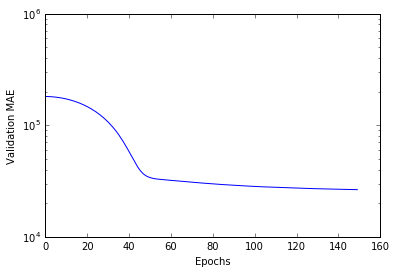

In [83]:
#plot the validation progression accross epochs
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), average_mae_history)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

In [84]:
#View final validation metric
print('the final validation metric was', average_mae_history[-1:])

the final validation metric was [26457.57046789266]


In [85]:
from keras.models import load_model

# returns a compiled model from prior saved architecture and weightings
modelf = load_model('housing_model_8-14-17_r4.h5')

In [86]:
# apply uploaded model to extract prediuctions from test data
results = modelf.predict(x_test_np)
results

array([[ 122200.2421875],
       [ 177478.84375  ],
       [ 178424.890625 ],
       ..., 
       [ 161607.171875 ],
       [ 121703.0078125],
       [ 232529.6875   ]], dtype=float32)

In [87]:
#convert results array to pandas dataframe with column label
results_df = pd.DataFrame(results, columns=['SalePrice'])
#results_df[:5]

# concatinate the id labels column with the rest of our training data
submission3 = pd.concat([labels_test, results_df], axis=1)

# export submission to csv
submission3.to_csv('submission3.csv', index=False)

Well this final attempt didn't help, so will have to revert to 85 units in hidden layer and 300 epochs as baseline. Current high score is 0.24734, 1429th place. This search process is not one where my limited experience will add much value, so instead will simply set this aside until have a GPU instance in hand and have figured out how to automate the hyperparameter serch process. A job is only as easy as the tools you bring to bear - why try to use a hammer when a screwdriver is needed know what I mean?

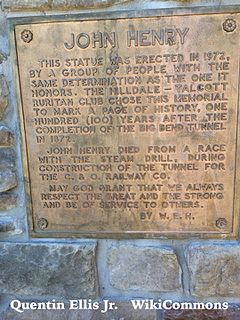

# Conclusion

This has been a fun experiment, although still leaves a little to be desired from the leaderboard standpoint. Will post this on github in case has potential to help any others get started with kaggle. This is an interesting time for this competition because parallel there is a more advanced version of this home price prediciton regression problem going on with cash prizes - so this set could be a warm-up for a real opportunity!

Note that I occasionally blog in a creative capacity on medium but sometimes touch on areas of professional interest - I wrote a bit about the emerging field of deep learning in a post if you'd like to see more - [From the Diaries of John Henry](https://medium.com/@_NicT_/from-the-diaries-of-john-henry-43dca78618b5). If you enjoyed or got any value from this writeup feel free to say hello, I'm on twitter at [@_nict_](https://twitter.com/_NicT_) or for professional inquiries can be reached on [linkedin](https://www.linkedin.com/in/nicholaste/). Happy learning!


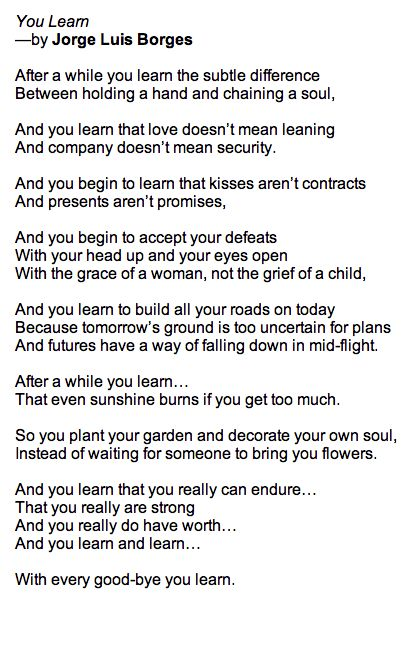